# A: **Qual o modelo de aprendizado que provavelmente seria mais certeiro em prever os sentimentos de uma review de um filme ??**

# **G: Vamos fazer um teste primeiro. Vamos pegar um dataset com 50 mil reviews do IMDB, que diferem entre positivas e negativas.**

Vamos fazer um teste primeiro. Vamos pegar um dataset com 50 mil reviews do IMDB, que diferem entre positivas e negativas.

In [ ]:
import pandas as pd
df_review = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# **E: Vamos agora explorar e transformar nossos dados.**

O projeto FMF nos dá a sugestão de utilizarmos 10 mil dados para que o modelo seja treinado mais rápido. Além disso, ele divide esses dados de maneira desbalanceada, pegando 9 mil positivos e mil negativos, a fim de utilizar técnicas de undersampling e oversampling

In [ ]:
df_positive = df_review[df_review['sentiment'] == 'positive'][:9000]
df_negative = df_review[df_review['sentiment'] == 'negative'][:1000]

df_review_imdb = pd.concat([df_positive,df_negative])

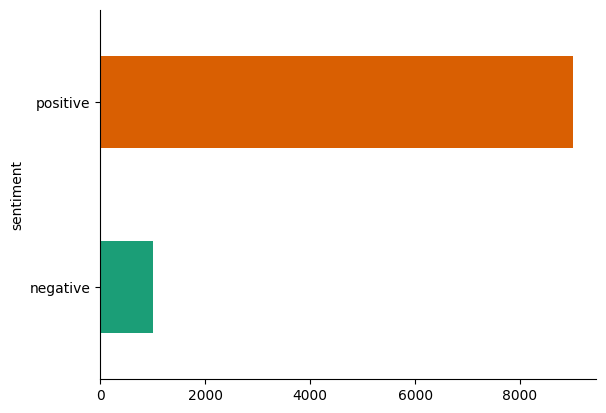

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_review_imdb.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Como podemos ver, existem muitos mais dados para uma classe do que pra outra, o que geralmente ocorre na maioria das situações que vamos encontrar. Essa ocasião se chama Dados Desbalanceados. Vamos focar na técnica de undersampling, já que é mais fácil diminuírmos os dados da classe majoritária do que criar novos dados para a classe minoritária, a fim de evitar duplas instâncias.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
df_review_bal, df_review_bal['sentiment']=rus.fit_resample(df_review_imdb[['review']],
df_review_imdb['sentiment'])
df_review_bal


,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


In [ ]:
print(df_review_imdb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
Name: count, dtype: int64
sentiment
negative    1000
positive    1000
Name: count, dtype: int64


Nesse bloco acima, utilizamos a biblioteca "imbalanced-learn" para realizar um undersampling aleatório, e a função "RandomUnderSampler" para aplicar esse undersampling. O parâmetro "random_state=0" é definido para garantir que os resultados sejam reprodutíveis, ou seja, a mesma amostra será obtida toda vez que o código for executado.



In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

Já nesse bloco, utilizamos a função "train_test_split" da biblioteca sklearn para dividir o conjunto de dados em conjuntos de treinamento e teste. Nesse caso, definimos o tamanho do conjunto de teste com 33%, enquanto os outros 67% serão utilizados para treinamento. Já o parâmetro "random_state" nos garante que a sequência de operações aleatórias será a mesma em todas as execuções do código, a fim de termos uma comparação justa e precisa entre as diferentes execuções do código. Escolhemos o valor 42 apenas por ser um valor popular entre a comunidade do Machine Learning, mas o valor em si não possui importância técnica; qualquer número pode ser utilizado para a mesma finalidade. Já no código abaixo vamos separar os dados obtidos em categorias

In [ ]:
train_x = train['review']
train_y = train['sentiment']
test_x= test['review']
test_y = test['sentiment']

train_x: Variáveis independentes (reviews) que serão usadas para treinar o modelo. Como especificamos test_size = 0.33, 67% das observações dos dados serão usadas para ajustar o modelo.

train_y: Variáveis dependentes (sentimento) que são as respostas corretas que o modelo aprende durante o processo de treinamento.

test_x: Os 33% restantes das variáveis independentes que serão usadas para fazer previsões e testar a precisão do modelo.

test_y: São as labels do conjunto de dados de teste. Essas são as respostas corretas usadas para avaliar a performance do modelo após o treinamento.


In [ ]:
train_y.value_counts()

sentiment
negative    675
positive    665
Name: count, dtype: int64

Aqui podemos ver que, dos 67% dos dados utilizados para treinamento, 675 são negativos, e 665 são positivos

# **M: Nosso objetivo agora é ajustar e modificar os dados para conseguirmos trabalhar com eles**

Ok, já preparamos o terreno e os dados. No entanto, classificadores e algoritmos de aprendizado esperam vetores numéricos em vez de documentos de texto brutos. É por isso que precisamos transformar o texto das reviews em vetores numéricos. Temos várias opções de técnicas, como one-hot encoding, Word2Vec e Bag of Words (BoW). Entretanto, cada uma delas é melhor para certo caso.

Para textos e vocabulários mais curtos, o one-hot encoding é ideal. Já para textos maiores e onde a análise semântica é necessária, utilizamos o Word2Vec. Como nossas reviews tem um vocabulário mais extenso, mas a análise semântica não é necessária, vamos utilizar o BoW.


Primeiro, para podermos identificar palavras que representam as reviews positivas e negativas, vamos utilizar a TF-IDF, que é uma função que computa um "peso" que represente o quão importante certa palavra é para uma coleção de documentos. O valor da TF-IDF aumenta proporcionalmente ao número de vezes que a palavra é citada no documento, e compensado pelo número de documentos que contenham a palavra. Entretanto, sabemos que temos palavras comuns, como "and", "the", "is", e que são muito utilizadas nas reviews. Por isso, colocamos a instância "stop_words" para desconsiderarmos essas palavras, que acabam por não contribuir significamente no documento.

Já o método "tfidf.fit_transform(train_x)" serve para calcularmos os pesos de cada palavra e já transformarmos elas em vetores. Com os pesos calculados e vetores transformados, guardamos elas em uma matriz esparsa (a maioria dos elementos tem valor zero), pois a maioria das palavras não aparece em cada documento, o que economiza memória.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
test_x_vector = tfidf.transform(test_x)

Com o resultado, podemos perceber que:


*   Temos 1340 documentos e 20625 palavras únicas
*   Desses, 118834 elementos são diferentes de zero e foram armazenados.



In [ ]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=tfidf.get_feature_names_out())


,00,000,007,01pm,02,04,08,10,100,1000,...,zooming,zooms,zues,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,ísnt,ïn,ünfaithful
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042791,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finalmente, vamos treinar nossos dados. Podemos identificar com clareza nossa entrada e saída. Logo, podemos dizer que nossos dados são rotulados, e por consequência, que estamos lidando com aprendizado supervisionado.

Dois tipos comuns de algoritmos de aprendizado supervisionado são Regressão e Classificação.

Regressão: Eles são usados para prever valores contínuos, como preço, salário, idade, etc.
Classificação: Eles são usados para prever valores discretos, como masculino/feminino, spam/não spam, positivo/negativo, etc.

Agora que sabemos que teremos que lidar com algoritmos de classificação de Aprendizado Supervisionado, vamos usar alguns modelos de exemplo, e no final, avaliar a performance de cada um

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)


DecisionTreeClassifier()

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(train_x_vector, train_y)

LogisticRegression()

# **C: Modelos treinados, agora vamos ver a pontuação de cada um e sua precisão:**

In [ ]:
print(svc.score(test_x_vector, test_y))
print(dec_tree.score(test_x_vector, test_y))
print(gnb.score(test_x_vector.toarray(), test_y))
print(log_reg.score(test_x_vector, test_y))

0.8409090909090909
0.6666666666666666
0.6348484848484849
0.8303030303030303


A SVM com kernel linear obteve a maior precisão. Este desempenho superior pode ser atribuído à capacidade da SVM de lidar bem com dados de alta dimensionalidade, como textos vetorizados com TF-IDF.

A Regressão Logística alcançou uma precisão de 0.8303, muito próxima da SVM. Este resultado é esperado, pois a Regressão Logística também é um modelo robusto para problemas de classificação binária, especialmente quando as classes são aproximadamente lineares.

O classificador de Árvore de Decisão teve uma precisão de 0.6409. Embora as árvores de decisão sejam intuitivas e fáceis de interpretar, elas tendem a sofrer de overfitting, especialmente em conjuntos de dados de alta dimensionalidade e complexos como textos vetorizados.

O Naive Bayes (GaussianNB) apresentou a menor precisão, 0.6348. Embora o Naive Bayes seja conhecido por sua eficiência e simplicidade, ele faz a suposição forte de independência entre as características, o que raramente é verdadeiro em textos. No caso de análise de sentimentos, as palavras em uma resenha não são completamente independentes umas das outras.

Vamos agora fazer um relatório mais detalhado da pontuação do nosso modelo:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



A tabela nos diz que:

* Precision: Das predições feitas como "positive", 83% eram realmente positivas, enquanto das predições feitas como "negative", 85% eram realmente negativas;
* Recall: Das amostras que eram realmente positivas, 87% foram corretamente identificadas como positivas, enquanto das amostras que eram realmente negativas, 82% foram corretamente identificadas como negativas;
* F1-score: 0.85 - A média harmônica da precisão e do recall, balanceando ambas as métricas.

* Accuracy: O modelo acertou 84% das predições no total.
* Macro Avg: Média das métricas de precisão, revocação e F1-score entre todas as classes, tratando-as igualmente.
* Weighted Avg: Média ponderada das métricas de precisão, revocação e F1-score, considerando o número de amostras em cada classe.






In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y,
                            svc.predict(test_x_vector),
                            labels=['positive', 'negative'])

conf_mat

array([[290,  45],
       [ 60, 265]])

Para vermos o relatório em números brutos, podemos utilizar a Matriz de Confusão, que nos mostra que:
* Tivemos 290 verdadeiros Positivos
* Tivemos 45 falsos Positivos
* Tivemos 60 falsos Negativos
* Tivemos 265 verdadeiros Negativos


Mas o que podemos fazer com esses dados?

Depois de analisarmos o problema, buscar a melhor solução, e analisarmos a mesma, está na hora de potencializarmos o modelo.


In [ ]:
from sklearn.model_selection import GridSearchCV
#set the parameters
parameters = {'C': [1,4,8,16,32] ,'kernel':['linear', 'rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,parameters, cv=5)

svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

Nessa técnica, especificamos hiperparâmetros, como os potenciais de regularização e os tipos de kernel a serem testados. Depois disso, ajustamos os dados de treinamento, testamos todas as combinações de parâmetros e selecionamos a melhor.

In [ ]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


Aqui, obtivemos os melhores parâmetros, que seria com um SVM com kernel linear e C = 1. Ou seja, os mesmos parâmetros do nosso modelo inicial. Isso quer dizer que o modelo já está próximo do ótimo para os dados que você tem.




---



# **Ok, esse foi o projeto FMF. Agora o que podemos fazer para o nosso próprio projeto?**

Para o nosso projeto, decidimos transformar nosso **A**. Agora que sabemos qual é o modelo de aprendizado mais certeiro em prever os sentimentos de uma review de um filme, pensamos em adicionar uma nova funcionalidade: **Após o treinamento do modelo, o algoritmo consegue prever uma nota para cada review?**

# **A: Após o treinamento do modelo, o algoritmo consegue prever uma nota para cada review?**

# **G: Para isso, vamos repetir os passos essenciais do projeto FMF, e alterando de acordo com as nossas necessidades**

In [ ]:
df_positive = df_review[df_review['sentiment'] == 'positive'][:15000]
df_negative = df_review[df_review['sentiment'] == 'negative'][:15000]

df_review_imdb = pd.concat([df_positive,df_negative])

Dessa vez, vamos utilizar mais dados para termos uma precisão maior, aumentando para 15 mil positivos e 15 mil negativos

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_review_imdb, test_size=0.33, random_state=42)

Aqui, para a predição das notas, precisamos atribuir valores numéricos aos valores "positivo" e "negativo". Por isso, atribuímos o valor 5 ao positivo, e o valor 1 ao negativo

In [ ]:
train_x = train['review']
train_y = train['sentiment'].map({'positive': 5, 'negative': 1})
test_x = test['review']
test_y = test['sentiment'].map({'positive': 5, 'negative': 1})

In [ ]:
train_y.value_counts()

sentiment
1    10096
5    10004
Name: count, dtype: int64

Nesse caso, teremos 10096 dados negativos e 10004 dados positivos para treino.

# **E: hora de criarmos nosso modelo, mas dessa vez, colocando todos os parâmetros necessários para termos a melhor precisão possível**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
test_x_vector = tfidf.transform(test_x)

In [ ]:
from sklearn.svm import SVC

svc =   SVC(kernel='linear', C=1, probability=True)
svc.fit(train_x_vector, train_y)

SVC(C=1, kernel='linear', probability=True)

# **M: Dessa vez, vamos ajustar os dados para atingir nosso novo objetivo: conseguir prever as notas das reviews, variando de 1 a 5.**

Primeiro, vamos usar o modelo SVM para prever quais das reviews são positivas, o qual retorna um array com as probabilidades estimadas para cada classe. Cada linha corresponde a uma amostra (review) e cada coluna corresponde a uma classe (positivo ou negativo). Com isso, criamos uma função para calcular a nota em si, com a fórmula 1 + (4* proba); Isto é:


*   Se a probabilidade for 0, a nota será 1
*   Se a probabilidade for 0.5, a nota será 3
*   Se a probabilidade for 1, a notá será 5




In [ ]:
y_proba = svc.predict_proba(test_x_vector)[:, 1]

def proba_to_rating(proba):
    return 1 + (4 * proba)

ratings = proba_to_rating(y_proba)

Agora, vamos usar o erro quadrático médio (MSE), uma medida que indica a média dos erros quadrados entre as notas reais e previstas, para avaliar a precisão do modelo. Quanto menor o MSE, mais próximas as reviews estão dos valores reais.



In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse = mean_squared_error(test_y, ratings)
print(f"Mean Squared Error: {mse:.2f}")

sample_reviews = test_x[:10]
sample_ratings = ratings[:10]

for review, rating in zip(sample_reviews, sample_ratings):
    print(f"Review: {review}\nPredicted Rating: {rating:.2f}\n")

Mean Squared Error: 1.30
Review: In celebration of Earth Day Disney has released the film "Earth". Stopping far short of any strident message of gloom and doom, we are treated to some excellent footage of animals in their habitats without feeling too bad about ourselves.<br /><br />The stars of the show are a herd of elephants, a family of polar bears and a whale and its calf. The narrative begins at the North Pole and proceeds south until we reach the tropics, all the while being introduced to denizens of the various climatic zones traversed.<br /><br />Global warming is mentioned in while we view the wanderings of polar bear; note is made of the shrinking sea ice islands in more recent years. We never see the bears catch any seals, but the father's desperate search for food leads him to a dangerous solution.<br /><br />The aerial shots of caribou migrating across the tundra is one of the most spectacular wildlife shots I ever saw; it and another of migrating wildfowl are enough to re

Aqui, temos um MSE de 1.30, ou seja, os valores estão próximos dos valores reais, mas isso dificulta que o algoritmo consiga identificar corretamente reviews mistas. O MSE é uma métrica útil, mas deve ser complementada com outras métricas de classificação para uma avaliação mais completa do desempenho do modelo. Previsões intermediárias para reviews que são originalmente rotuladas como extremas (1 ou 5) podem inflacionar o valor do MSE. Portanto, é importante considerar métricas adicionais, como a matriz de confusão, precisão, recall e F1-score, para entender melhor a performance do modelo em diferentes cenários.



# C: Agora que a nossa versão está treinada, vamos mostrar os resultados e a acurácia do modelo:




In [ ]:
predicted_labels = ['positive' if rating >= 3 else 'negative' for rating in ratings]
true_labels = ['positive' if rating >= 3 else 'negative' for rating in test_y]

# Gerar o relatório de classificação
print(classification_report(true_labels, predicted_labels, labels=['positive', 'negative']))


              precision    recall  f1-score   support

    positive       0.89      0.90      0.89      4996
    negative       0.90      0.88      0.89      4904

    accuracy                           0.89      9900
   macro avg       0.89      0.89      0.89      9900
weighted avg       0.89      0.89      0.89      9900



Com 30 mil dados, tivemos um aumento geral de 84% para 89% de previsões certas.

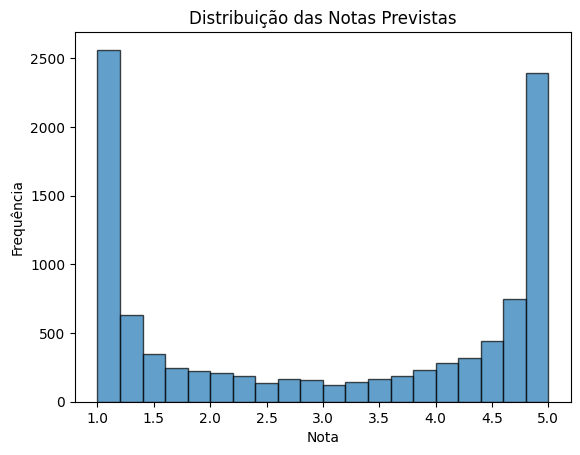

In [ ]:
plt.hist(ratings, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribuição das Notas Previstas')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()


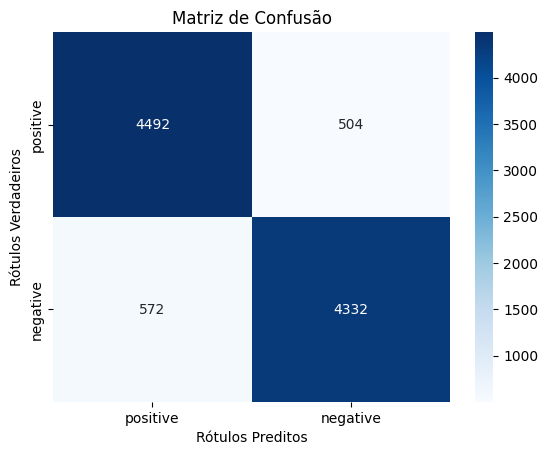

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter notas previstas para rótulos categóricos
predicted_labels = ['positive' if rating >= 3 else 'negative' for rating in ratings]
true_labels = ['positive' if rating >= 3 else 'negative' for rating in test_y]

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['positive', 'negative'])

# Visualizar a matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Preditos')
plt.ylabel('Rótulos Verdadeiros')
plt.show()


In [ ]:
# Criar DataFrame com as reviews originais e as notas previstas
df_predictions = pd.DataFrame({'review': test_x, 'actual_sentiment': test['sentiment'], 'predicted_rating': ratings})

# Salvar DataFrame em um arquivo CSV
df_predictions.to_csv('/content/drive/MyDrive/reviews_with_predicted_ratings.csv', index=False)
